Rupesh Bharambe (AI3107)

In [2]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

In [3]:
IMG_SIZE = 224

In [4]:
# Load dataset
def load_data(directory):
    data, labels = [], []
    for class_name in sorted(os.listdir(directory)):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue
        for img_name in os.listdir(class_path):
            try:
                img_path = os.path.join(class_path, img_name)
                image = cv2.imread(img_path)
                image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
                image = image.astype("float32") / 255.0
                data.append(image)
                labels.append(class_name)
            except:
                print(f"Error loading image: {img_path}")
    return np.array(data), np.array(labels)

trainX, trainY = load_data('VegetableDataset/train')
validX, validY = load_data('VegetableDataset/validation')
testX, testY = load_data('VegetableDataset/test')

Error loading image: VegetableDataset/train\bell pepper\Image_56.jpg


In [5]:
le = LabelEncoder()
trainY = to_categorical(le.fit_transform(trainY))
validY = to_categorical(le.transform(validY))
testY = to_categorical(le.transform(testY))

In [6]:
# Load VGG16 base model
baseModel = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))


In [7]:
# Freeze all layers (feature extraction)
for layer in baseModel.layers:
    layer.trainable = False


In [8]:
# Add custom classifier
model = Sequential([
    baseModel,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(trainY.shape[1], activation='softmax')
])

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [10]:
# Train the model
print("[INFO] Training VGG16 feature extractor...")
H = model.fit(trainX, trainY,
          validation_data=(validX, validY),
          batch_size=32,
          epochs=10,
          verbose=1)

[INFO] Training VGG16 feature extractor...
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 250s 3s/step - accuracy: 0.1152 - loss: 4.4456 - val_accuracy: 0.6638 - val_loss: 1.5904
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - accuracy: 0.3675 - loss: 2.1871 - val_accuracy: 0.7806 - val_loss: 1.0801
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 257s 3s/step - accuracy: 0.4993 - loss: 1.7028 - val_accuracy: 0.9145 - val_loss: 0.5703
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 252s 3s/step - accuracy: 0.6093 - loss: 1.2735 - val_accuracy: 0.9174 - val_loss: 0.4555
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 254s 3s/step - accuracy: 0.6348 - loss: 1.1719 - val_accuracy: 0.9088 - val_loss: 0.3365
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 246s 3s/step - accuracy: 0.6949 - loss: 0.9563 - val_accuracy: 0.9402 - val_loss: 0.2656
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 256s 3s/step - accuracy: 0.7180 - loss: 0.8573 - val_accuracy: 0.9573 - val_loss: 0.2261
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 248s 3s/step - accuracy: 0.744

In [11]:
# Evaluate
loss, acc = model.evaluate(testX, testY)
print(f"Test Accuracy (feature extraction): {acc*100:.2f}%")


12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9552 - loss: 0.2116
Test Accuracy (feature extraction): 96.94%


VGG Finetuning

In [12]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [13]:
# [1] Unfreeze last convolutional block of baseModel
for layer in baseModel.layers:
    layer.trainable = False
for layer in baseModel.layers[-4:]:  # You can increase this if needed
    layer.trainable = True


In [14]:
# [2] Rebuild model with shared baseModel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

In [15]:
# Rebuild from functional API to avoid re-wrapping baseModel
x = baseModel.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
preds = Dense(trainY.shape[1], activation='softmax')(x)

model_finetune = Model(inputs=baseModel.input, outputs=preds)

In [16]:
# [3] Compile with lower learning rate for fine-tuning
model_finetune.compile(optimizer=Adam(learning_rate=1e-5),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

In [17]:
# [4] Set up callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [18]:
# [5] Train the fine-tuned model
print("[INFO] Fine-tuning VGG16...")
H_fine = model_finetune.fit(trainX, trainY,
                            validation_data=(validX, validY),
                            batch_size=32,
                            epochs=10,
                            callbacks=[reduce_lr, early_stop],
                            verbose=1)

[INFO] Fine-tuning VGG16...
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 288s 3s/step - accuracy: 0.0415 - loss: 3.8002 - val_accuracy: 0.4387 - val_loss: 2.8301 - learning_rate: 1.0000e-05
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 289s 3s/step - accuracy: 0.2203 - loss: 2.9331 - val_accuracy: 0.7293 - val_loss: 1.5526 - learning_rate: 1.0000e-05
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 294s 3s/step - accuracy: 0.4635 - loss: 1.9876 - val_accuracy: 0.8661 - val_loss: 0.7677 - learning_rate: 1.0000e-05
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 295s 3s/step - accuracy: 0.6077 - loss: 1.3948 - val_accuracy: 0.9174 - val_loss: 0.4478 - learning_rate: 1.0000e-05
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 287s 3s/step - accuracy: 0.7312 - loss: 0.9788 - val_accuracy: 0.9544 - val_loss: 0.2815 - learning_rate: 1.0000e-05
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 286s 3s/step - accuracy: 0.8113 - loss: 0.7050 - val_accuracy: 0.9658 - val_loss: 0.2012 - learning_rate: 1.0000e-05
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 298s

In [19]:
# [6] Evaluate
loss, acc = model_finetune.evaluate(testX, testY)
print(f"Test Accuracy (fine-tuned): {acc*100:.2f}%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9511 - loss: 0.2026
Test Accuracy (fine-tuned): 96.94%


In [20]:
def plot_training_history(H, title="Training History"):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(H.history['accuracy'], label='Train Accuracy')
    plt.plot(H.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(H.history['loss'], label='Train Loss')
    plt.plot(H.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


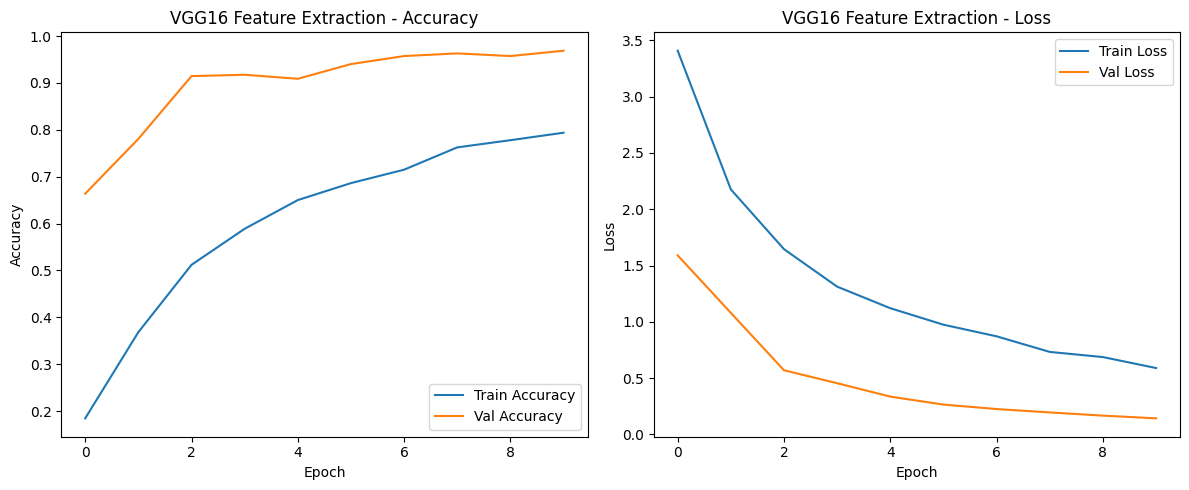

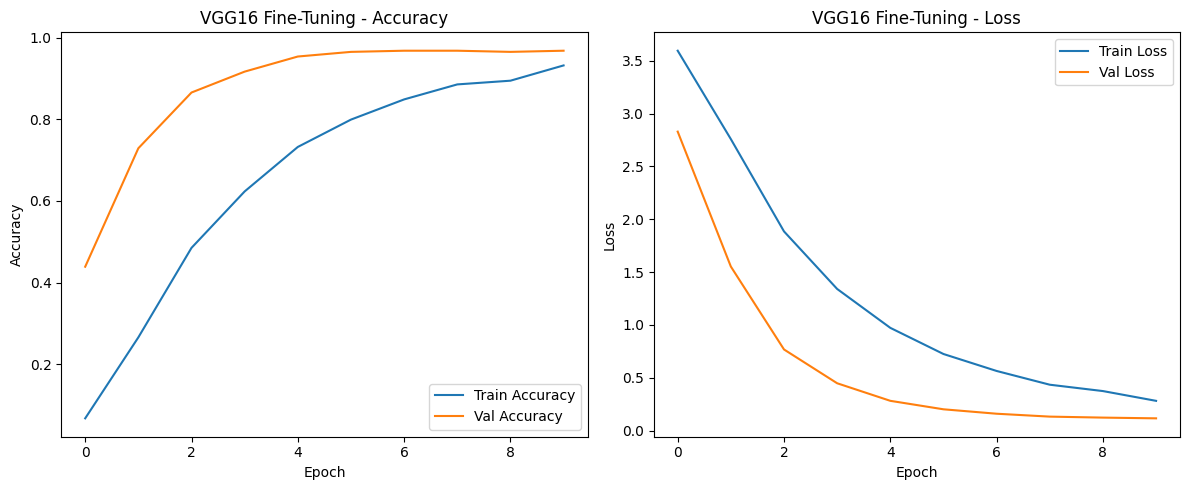

In [21]:
plot_training_history(H, title="VGG16 Feature Extraction")
plot_training_history(H_fine, title="VGG16 Fine-Tuning")

In [22]:
# Save fine-tuned model
model_finetune.save("vgg16_finetuned_vegetables.h5")
print("Model saved successfully.")


Model saved successfully.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


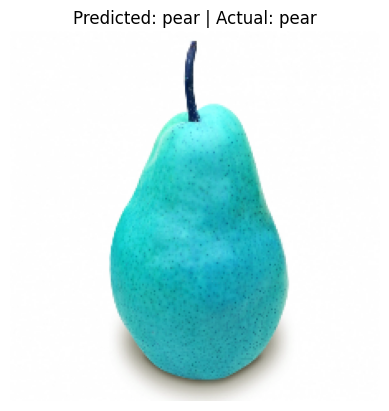

In [23]:
import random
from tensorflow.keras.models import load_model

# Load the saved model
model_loaded = load_model("vgg16_finetuned_vegetables.h5")

# Inverse transform to get class names back
inv_class_names = le.inverse_transform(np.arange(trainY.shape[1]))

# Choose a random sample from test set
idx = random.randint(0, len(testX) - 1)
sample = testX[idx]
true_label = inv_class_names[np.argmax(testY[idx])]

# Predict
pred = model_loaded.predict(np.expand_dims(sample, axis=0))[0]
pred_label = inv_class_names[np.argmax(pred)]

# Show prediction
plt.imshow(sample)
plt.title(f"Predicted: {pred_label} | Actual: {true_label}")
plt.axis('off')
plt.show()
